<a href="https://colab.research.google.com/github/bhuiyanmobasshir94/Cow-weight-and-Breed-Prediction/blob/main/notebooks/027_dec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [77]:
import numpy as np
import pandas as pd
import sys
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import pathlib
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [48]:
## Globals 
YT_IMAGE_TO_TAKE = 4

In [2]:
images_dataset_url = "https://cv-datasets-2021.s3.amazonaws.com/images.tar.gz"
images_data_dir = tf.keras.utils.get_file(origin=images_dataset_url,
                                   fname='images',
                                   untar=True)
images_data_dir = pathlib.Path(images_data_dir)

833060864/833046463 [==============================] - 16s 0us/step


In [3]:
yt_images_dataset_url = "https://cv-datasets-2021.s3.amazonaws.com/yt_images.tar.gz"
yt_images_data_dir = tf.keras.utils.get_file(origin=yt_images_dataset_url,
                                   fname='yt_images',
                                   untar=True)
yt_images_data_dir = pathlib.Path(yt_images_data_dir)

4027006976/4026992587 [==============================] - 64s 0us/step


In [4]:
if sys.platform == 'darwin':
  os.system(f"dot_clean {images_data_dir}")
  os.system(f"dot_clean {yt_images_data_dir}")
elif sys.platform.startswith("lin"):
  os.system(f"cd {images_data_dir} && find . -type f -name '._*' -delete")
  os.system(f"cd {yt_images_data_dir} && find . -type f -name '._*' -delete")


In [49]:
image_count = len(list(images_data_dir.glob('*/*.jpg')))
print(image_count)

2056


In [50]:
yt_image_count = len(list(yt_images_data_dir.glob('*/*.jpg')))
print(yt_image_count)

15843


In [51]:
df = pd.read_csv("https://cv-datasets-2021.s3.amazonaws.com/dataset.csv")
df.shape

(513, 14)

In [52]:
df.head(2)

,sku,sex,color,breed,feed,age_in_year,teeth,height_in_inch,weight_in_kg,price,size,images_count,yt_images_count,total_images
0,BLF 2340,MALE_BULL,RED,LOCAL,"['JUMBOO', 'LUCERNE', 'NAPIER', 'SILAGE', 'STR...",2.0,2,50.9,270.0,19000.0,MEDIUM,4,0,4
1,BLF 2342,MALE_BULL,NON_RED,LOCAL,"['JUMBOO', 'LUCERNE', 'NAPIER', 'SILAGE', 'STR...",2.0,2,52.0,256.0,18000.0,LARGE,4,31,35


In [53]:
images = list(images_data_dir.glob('*/*.jpg'))
yt_images = list(yt_images_data_dir.glob('*/*.jpg'))

In [54]:
min_height = 0
max_height = 0
min_width = 0
max_width = 0
for i, image in enumerate(images):
  w, h = PIL.Image.open(str(image)).size
  if i == 0:
    min_height = h
    max_height = h
    min_width = w
    max_width = w
  
  if h <= min_height:
    min_height = h
  if h >= max_height:
    max_height = h

  if w <= min_width:
    min_width = w
  if w >= max_width:
    max_width = w

print(f"min_height: {min_height}")
print(f"min_width: {min_width}")
print(f"max_height: {max_height}")
print(f"max_width: {max_width}")

min_height: 450
min_width: 800
max_height: 675
max_width: 1200


In [55]:
min_height = 0
max_height = 0
min_width = 0
max_width = 0
for i, image in enumerate(yt_images):
  w, h = PIL.Image.open(str(image)).size
  if i == 0:
    min_height = h
    max_height = h
    min_width = w
    max_width = w

  if h <= min_height:
    min_height = h
  if h >= max_height:
    max_height = h

  if w <= min_width:
    min_width = w
  if w >= max_width:
    max_width = w

print(f"min_height: {min_height}")
print(f"min_width: {min_width}")
print(f"max_height: {max_height}")
print(f"max_width: {max_width}")

min_height: 720
min_width: 1280
max_height: 720
max_width: 1280


In [56]:
f_df = pd.DataFrame(columns = ['file_path', 'teeth', 'age_in_year', 'breed', 'height_in_inch', 'weight_in_kg'])
for index, row in df.iterrows():
  images = list(images_data_dir.glob(f"{row['sku']}/*.jpg"))
  yt_images = list(yt_images_data_dir.glob(f"{row['sku']}/*.jpg"))

  for image in images:
    f_df = f_df.append({'file_path' : image, 'teeth' : row['teeth'], 'age_in_year' : row['age_in_year'], 'breed': row['breed'], 'height_in_inch': row['height_in_inch'], 'weight_in_kg': row['weight_in_kg']}, 
                ignore_index = True)
    
  for idx, image in enumerate(yt_images):
    if idx == (YT_IMAGE_TO_TAKE - 1):
      break
    f_df = f_df.append({'file_path' : image, 'teeth' : row['teeth'], 'age_in_year' : row['age_in_year'], 'breed': row['breed'], 'height_in_inch': row['height_in_inch'], 'weight_in_kg': row['weight_in_kg']}, 
                ignore_index = True)


In [57]:
f_df.shape

(3585, 6)

In [58]:
f_df.head(1)

,file_path,teeth,age_in_year,breed,height_in_inch,weight_in_kg
0,/root/.keras/datasets/images/BLF 2340/BLF 2340...,2,2.0,LOCAL,50.9,270.0


In [78]:
def label_encode(df):
  teeth_le = preprocessing.LabelEncoder()
  df['teeth']= teeth_le.fit_transform(df['teeth'])
  breed_le = preprocessing.LabelEncoder()
  df['breed']= breed_le.fit_transform(df['breed'])
  age_in_year_le = preprocessing.LabelEncoder()
  df['age_in_year']= age_in_year_le.fit_transform(df['age_in_year'])
  print(teeth_le.classes_)
  print(breed_le.classes_)
  print(age_in_year_le.classes_)
  return df

def inverse_transform(le, series=[]):
  return le.inverse_transform(series)


In [79]:
f_df = label_encode(f_df)

[2 4 6]
['BRAHMA' 'HOSTINE_CROSS' 'LOCAL' 'MIR_KADIM' 'PABNA_BREED'
 'RED_CHITTAGONG' 'SAHIWAL' 'SINDHI']
[2.  2.5 3. ]


In [80]:
# train_df, valid_test_df = train_test_split(f_df, test_size=0.3)
# validation_df, test_df = train_test_split(valid_test_df, test_size=0.3)
# print(f"train_df: {train_df.shape}")
# print(f"validation_df: {validation_df.shape}")
# print(f"test_df: {test_df.shape}")

train_df, test_df = train_test_split(f_df, test_size=0.1)
print(f"train_df: {train_df.shape}")
print(f"test_df: {test_df.shape}")

train_df: (3226, 6)
test_df: (359, 6)


In [60]:
# min_height: 450
# min_width: 800

# input: [image, teeth]
# outpur: [age_in_year, breed, height_in_inch, weight_in_kg]

# class CustomDataGen(tf.keras.utils.Sequence):
    
#     def __init__(self, df, X_col, y_col,
#                  batch_size,
#                  input_size=(450, 800, 3), # (input_height, input_width, input_channel)
#                  shuffle=True):
        
#         self.df = df.copy()
#         self.X_col = X_col
#         self.y_col = y_col
#         self.batch_size = batch_size
#         self.input_size = input_size
#         self.shuffle = shuffle
        
#         self.n = len(self.df)
#         # self.n_teeth = df[X_col['teeth']].max()
#         # self.n_breed = df[y_col['breed']].nunique()
    
#     def on_epoch_end(self):
#         if self.shuffle:
#             self.df = self.df.sample(frac=1).reset_index(drop=True)
    
#     def __get_input(self, path, target_size):
#         image = tf.keras.preprocessing.image.load_img(path)
#         image_arr = tf.keras.preprocessing.image.img_to_array(image)

#         # image_arr = image_arr[ymin:ymin+h, xmin:xmin+w]
#         image_arr = tf.image.resize(image_arr,(target_size[0], target_size[1])).numpy()

#         return image_arr/255.
    
#     def __get_output(self, label, num_classes):
#         return tf.keras.utils.to_categorical(label, num_classes=num_classes)
    
#     def __get_data(self, batches):
#         # Generates data containing batch_size samples

#         path_batch = batches[self.X_col['file_path']]       
#         # teeth_batch = batches[self.X_col['teeth']]

#         # breed_batch = batches[self.y_col['breed']]
#         weight_in_kg_batch = batches[self.y_col['weight_in_kg']]
#         height_in_inch_batch = batches[self.y_col['height_in_inch']]
#         age_in_year_batch = batches[self.y_col['age_in_year']]

#         X0 = np.asarray([self.__get_input(x, self.input_size) for x in path_batch])

#         # y0_batch = np.asarray([self.__get_output(y, self.n_teeth) for y in teeth_batch])
#         # y1_batch = np.asarray([self.__get_output(y, self.n_breed) for y in breed_batch])

#         y0 = np.asarray([tf.cast(y, tf.float32) for y in weight_in_kg_batch])
#         y1 = np.asarray([tf.cast(y, tf.float32) for y in height_in_inch_batch])
#         y2 = np.asarray([tf.cast(y, tf.float32) for y in age_in_year_batch])

#         return X0, tuple([y0, y1, y2])
    
#     def __getitem__(self, index):
        
#         batches = self.df[index * self.batch_size:(index + 1) * self.batch_size]
#         X, y = self.__get_data(batches)        
#         return X, y
    
#     def __len__(self):
#         return self.n // self.batch_size

In [61]:
# traingen = CustomDataGen(train_df,
#                          X_col={'file_path':'file_path', 'teeth': 'teeth'},
#                          y_col={'breed': 'breed', 'weight_in_kg': 'weight_in_kg', 'height_in_inch': 'height_in_inch', 'age_in_year': 'age_in_year'},
#                          batch_size=128, input_size=(450, 800, 3))

In [62]:
# testgen = CustomDataGen(test_df,
#                          X_col={'file_path':'file_path', 'teeth': 'teeth'},
#                          y_col={'breed': 'breed', 'weight_in_kg': 'weight_in_kg', 'height_in_inch': 'height_in_inch', 'age_in_year': 'age_in_year'},
#                          batch_size=128, input_size=(450, 800, 3))

In [63]:
# validgen = CustomDataGen(validation_df,
#                          X_col={'file_path':'file_path', 'teeth': 'teeth'},
#                          y_col={'breed': 'breed', 'weight_in_kg': 'weight_in_kg', 'height_in_inch': 'height_in_inch', 'age_in_year': 'age_in_year'},
#                          batch_size=128, input_size=(450, 800, 3))

In [108]:
def __get_input(path, target_size):
  image = tf.keras.preprocessing.image.load_img(path)
  image_arr = tf.keras.preprocessing.image.img_to_array(image)
  image_arr = tf.image.resize(image_arr,(target_size[0], target_size[1])).numpy()
  return image_arr/255.

def data_loader(df, image_size=(450, 800, 3)):
  y0 = tf.cast(df.weight_in_kg, tf.float32)
  print(y0.shape)
  y1 = tf.cast(df.height_in_inch, tf.float32)
  print(y1.shape)
  # y2 = tf.cast(df.age_in_year, tf.float32)
  y2 = keras.utils.to_categorical(df.age_in_year)
  print(y2.shape)
  y3 = keras.utils.to_categorical(df.breed)
  print(y3.shape)

  path_batch = df.file_path
  X0 = tf.cast([__get_input(x, image_size) for x in path_batch], tf.float32)
  print(X0.shape)
  X1 = keras.utils.to_categorical(df.teeth)
  print(X1.shape)

  return (X0, X1), (y0, y1, y2, y3)

In [109]:
(X0, X1), (y0, y1, y2, y3) = data_loader(train_df, (150, 150, 3))

(3226,)
(3226,)
(3226, 3)
(3226, 8)
(3226, 150, 150, 3)
(3226, 3)


In [110]:
# input = keras.Input(shape=(128, 128, 3), name="original_img")
# x = layers.Conv2D(64, 3, activation="relu")(input)
# x = layers.Conv2D(128, 3, activation="relu")(x)
# x = layers.MaxPooling2D(3)(x)
# x = layers.Conv2D(128, 3, activation="relu")(x)
# x = layers.Conv2D(64, 3, activation="relu")(x)
# x = layers.GlobalMaxPooling2D()(x)

input0 = keras.Input(shape=(150, 150, 3), name="img")
x = layers.Conv2D(32, 3, activation="relu")(input0)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(64, 3, activation="relu")(x)
x = layers.GlobalMaxPooling2D()(x)

input1 = keras.Input(shape=(3,), name="teeth")


out_a = keras.layers.Dense(1, activation='linear', name='wt_rg')(x)
out_b = keras.layers.Dense(1, activation='linear', name='ht_rg')(x)
# out_c = keras.layers.Dense(1, activation='linear', name='ag_rg')(x)
out_c = keras.layers.Dense(3, activation='softmax', name='ag_3cls')(x)
out_d = keras.layers.Dense(8, activation='softmax', name='brd_8cls')(x)

encoder = keras.Model( inputs = [input0, input1] , outputs = [out_a, out_b, out_c, out_d], name="encoder")

In [111]:
encoder.compile(
    loss = {
        "wt_rg": tf.keras.losses.MeanSquaredError(),
        "ht_rg": tf.keras.losses.MeanSquaredError(),
        # "ag_rg": tf.keras.losses.MeanSquaredError()
        "ag_3cls": tf.keras.losses.CategoricalCrossentropy(),
        "brd_8cls": tf.keras.losses.CategoricalCrossentropy()
    },

    metrics = {
        "wt_rg": 'mse',
        "ht_rg": 'mse',
        "ag_3cls": 'accuracy',
        "brd_8cls": 'accuracy'
    },

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
)

In [127]:
encoder.fit([X0, X1], [y0, y1, y2, y3], epochs=30, verbose=2, batch_size=32, validation_split=0.2)

Epoch 1/30
81/81 - 3s - loss: 5945.3203 - wt_rg_loss: 5924.5801 - ht_rg_loss: 19.0003 - ag_3cls_loss: 0.6339 - brd_8cls_loss: 1.1059 - wt_rg_mse: 5924.5801 - ht_rg_mse: 19.0003 - ag_3cls_accuracy: 0.7372 - brd_8cls_accuracy: 0.6919 - val_loss: 4411.7466 - val_wt_rg_loss: 4392.2710 - val_ht_rg_loss: 17.7164 - val_ag_3cls_loss: 0.6191 - val_brd_8cls_loss: 1.1400 - val_wt_rg_mse: 4392.2710 - val_ht_rg_mse: 17.7164 - val_ag_3cls_accuracy: 0.7477 - val_brd_8cls_accuracy: 0.6796 - 3s/epoch - 42ms/step
Epoch 2/30
81/81 - 3s - loss: 5944.9971 - wt_rg_loss: 5924.1772 - ht_rg_loss: 19.0753 - ag_3cls_loss: 0.6339 - brd_8cls_loss: 1.1110 - wt_rg_mse: 5924.1772 - ht_rg_mse: 19.0753 - ag_3cls_accuracy: 0.7353 - brd_8cls_accuracy: 0.6919 - val_loss: 4381.1943 - val_wt_rg_loss: 4361.7974 - val_ht_rg_loss: 17.6232 - val_ag_3cls_loss: 0.6331 - val_brd_8cls_loss: 1.1405 - val_wt_rg_mse: 4361.7974 - val_ht_rg_mse: 17.6232 - val_ag_3cls_accuracy: 0.7477 - val_brd_8cls_accuracy: 0.6796 - 3s/epoch - 38ms/ste

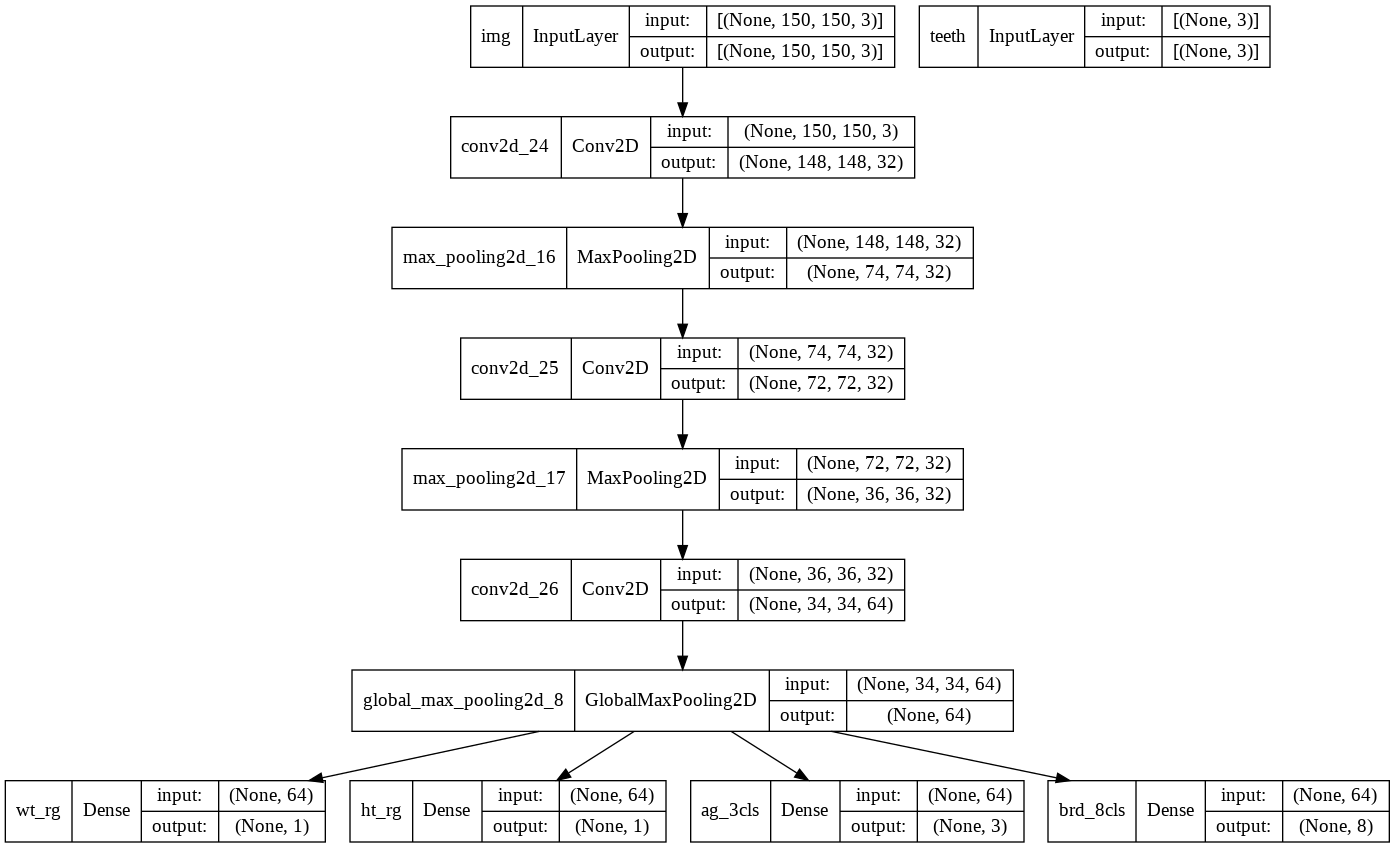

In [128]:
# encoder.output
keras.utils.plot_model(encoder, "encoder.png", show_shapes=True)

In [129]:
(tX0, tX1), (ty0, ty1, ty2, ty3) = data_loader(test_df, (150, 150, 3))

(359,)
(359,)
(359, 3)
(359, 8)
(359, 150, 150, 3)
(359, 3)


In [130]:
test_scores = encoder.evaluate([tX0, tX1], [ty0, ty1, ty2, ty3], verbose=2)

12/12 - 0s - loss: 6155.5669 - wt_rg_loss: 6136.5771 - ht_rg_loss: 17.2318 - ag_3cls_loss: 0.6344 - brd_8cls_loss: 1.1239 - wt_rg_mse: 6136.5771 - ht_rg_mse: 17.2318 - ag_3cls_accuracy: 0.7577 - brd_8cls_accuracy: 0.6713 - 236ms/epoch - 20ms/step


In [131]:
print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1])

Test loss: 6155.56689453125
Test accuracy: 6136.5771484375


In [137]:
p0, p1, p2, p3 = encoder.predict([tf.expand_dims(tX0[0], 0), tf.expand_dims(tX1[0], 0)])

In [138]:
print(p0);ty0[0]

[[257.80487]]


<tf.Tensor: shape=(), dtype=float32, numpy=248.0>

In [139]:
print(p1);ty1[0]

[[47.21805]]


<tf.Tensor: shape=(), dtype=float32, numpy=48.0>

In [140]:
print(p2.argmax());ty2[0].argmax()

0


1

In [141]:
print(p3.argmax());ty3[0].argmax()

2


7